The following project focus on the analysis of a dataset containg informations about engineering students.<br>
The goal of the project is to determine which factors have a higher impact on job placement.<br>

First, Exploratory Data Analysis and Hypothesis Testing will be performed to determine possible relationships between a job placement success and other features. Later, prediction models by CATBOOST and XGBOOST will be developed to predict if a student will be placed or not given some students features.<br>

The project is structured as follows:<br>

- Exploratory Data Analysis and Hypothesis Testing<br>
- Data preparation for ML algorithms (encoding, scaling)<br>
- ML algorithms training<br>
- Results Summary<br>

# Data Analysis main results summary dashboard:

- Q1 - CGPA and placement are not independent: in particular, CGPA affects a lot placement as it can be seen in the prediction summary
- Q2 - The number of internships affects placement: in particular, a higher number of internships affects plcament positively.
- Q3 - Sex and placement are independent.
- Q4 - Students who did not have historical backlogs tended to be placed.
- Q5 - Students who did not live in a college accomodation tended to be placed.
- Q6 - It seems like there is no clear relationship between age and 'placed'.
- Q7 - Age and the number of internships are somewhat dependent.
- Q8 - The majority of students from Computer Science, IT and Electronic got placed.
- Q9 - The major where most students did at least one internship is Computer Science (67%), while for Civil, Electrical and Mechanical engineering more than half of the students did not do any internship. Morevoer, Electronic and IT are the majors where most students did 2 or more internships. Finally, Civil and Mechanical are the majors where over 7% of the students have CGPA=9, whereas students from Electrical engineering are those with most CGPA=8 or CGPA=7.

<img src="https://i.imgur.com/Dfgo5Fq.png" width="1000px">

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

from scipy import stats
from scipy.stats import shapiro
from scipy.stats import chi2_contingency
from scipy.stats import chi2


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, auc, roc_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold




seed=2042 


plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

## Custom functions definition

In [3]:
def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, figsize=(5.2,5),gridspec_kw={"height_ratios": (.1, .9)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(y='placed', x=col, data=df, orient='h', palette=palette, ax=ax[0])
    ax[0].set(yticks=[])
    ax[0].set_ylabel('')
    ax[0].set_xlabel('')
    sns.countplot(x=col, data=df, ax=ax[1], hue='placed',palette=palette)
    ax[1].set_xlabel(col, fontsize=16)
    ax[1].set_yticks([])
    for container in ax[1].containers:
        ax[1].bar_label(container,fmt='%.1f')
    plt.legend(title='Placed?', title_fontsize=14, labels=['no', 'yes'], fontsize=13, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()

In [4]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

In [5]:
def conf_matrix(y, y_pred):
    fig, ax =plt.subplots(figsize=(3.5,3.5))
    labels=['No','Yes']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title('Placed?', fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test')
    ax.set_xlabel('Predicted')

## Importing the Data

The dataset has the following columns:
- Age : Age At The Time Of Final Year 
- Gender : Gender Of Candidate 
- Stream : Engineering Stream That The Candidate Belongs To
- Internships : Number Of Internships Undertaken During The Course Of Studies, Not Necessarily Related To College Studies Or Stream
- CGPA : CGPA Till 6th Semester
- Hostel : Whether Student Lives In College Accomodation
- HistoryOfBacklogs : Whether Student Ever Had Any Backlogs In Any Subjects
- PlacedOrNot : Target Variable

In [6]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\collegePlace.csv")

In [7]:
df.head()

,Age,Gender,Stream,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
0,22,Male,Electronics And Communication,1,8,1,1,1
1,21,Female,Computer Science,0,7,1,1,1
2,22,Female,Information Technology,1,6,0,0,1
3,21,Male,Information Technology,0,8,0,1,1
4,22,Male,Mechanical,0,8,1,0,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                2966 non-null   int64 
 1   Gender             2966 non-null   object
 2   Stream             2966 non-null   object
 3   Internships        2966 non-null   int64 
 4   CGPA               2966 non-null   int64 
 5   Hostel             2966 non-null   int64 
 6   HistoryOfBacklogs  2966 non-null   int64 
 7   PlacedOrNot        2966 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 185.5+ KB


Good, apparently there are no missing values !

In [9]:
df.describe()

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
count,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000,2966.000000
mean,21.485840,0.703641,7.073837,0.269049,0.192178,0.552596
std,1.324933,0.740197,0.967748,0.443540,0.394079,0.497310
min,19.000000,0.000000,5.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,6.000000,0.000000,0.000000,0.000000
50%,21.000000,1.000000,7.000000,0.000000,0.000000,1.000000
75%,22.000000,1.000000,8.000000,1.000000,0.000000,1.000000
max,30.000000,3.000000,9.000000,1.000000,1.000000,1.000000


In [10]:
df.describe().loc[['mean', 'min', 'max']]

,Age,Internships,CGPA,Hostel,HistoryOfBacklogs,PlacedOrNot
mean,21.48584,0.703641,7.073837,0.269049,0.192178,0.552596
min,19.00000,0.000000,5.000000,0.000000,0.000000,0.000000
max,30.00000,3.000000,9.000000,1.000000,1.000000,1.000000


We can already get useful information about some features !
- Age is between 19 and 30
- Minimum number of internships is 0 (no internships) while the max is 3
- The majority of students in the dataset did not live in a hostel (Hostel mean is lower than 0.5), 
- The majority of students does not have backlogs (HistoryOfBacklogs mean is lower than 0.5)
- The majority of students have been placed (PlacedOrNot mean is higher than 0.5)

Moreover, to simplify further analysis, some columns will be renamed as follows:

In [11]:
df.rename(columns={'HistoryOfBacklogs': 'backlogs', 'PlacedOrNot': 'placed'}, inplace=True)

And the other columns will be transformed into lowercase

In [12]:
df = df.rename(columns=str.lower)

# Exploratory Data Analysis and Hypothesis Testing

We set a palette to improve the following plots readability: we specify the color to be green if the student got placed (placed=1) and red if placed=0.

In [13]:
palette = {1:'#46C646', 0:'#FF0000'}

We start the analysis by checking the linear correlation (Pearson correlation) between the features:

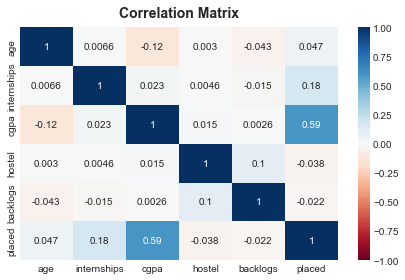

In [14]:
sns.heatmap(df.corr(), cmap='RdBu', annot=True, vmin=-1, vmax=1)
plt.title('Correlation Matrix');

By looking at the correlation matrix we can say:
- Quite high linear positive correlation between placed and CGPA (0.59): students with higher CGPA tends to be placed
- Small linear positive betwen internships and placed (0.18): students with internships tends to be placed

The other linear correlations coefficients look somewhat low. Let's investigate more! 

# How does CGPA affect job placement?

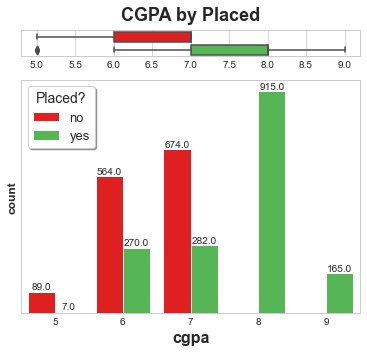

In [15]:
num_plot(df, 'cgpa', 'CGPA by Placed', '')

From these plots we can see that the average CGPA of placed students in higher than the CGPA of not placed students.<br>
In particular, from the boxplot we can see that there are some students with a low cgpa (cgpa=5) that still got placed.<br>
Who are these students?

In [16]:
df.loc[(df['cgpa'] == 5) & (df['placed'] == 1)]

,age,gender,stream,internships,cgpa,hostel,backlogs,placed
118,24,Male,Information Technology,3,5,0,1,1
122,23,Male,Information Technology,1,5,0,0,1
137,24,Male,Information Technology,0,5,0,0,1
140,23,Male,Computer Science,1,5,0,0,1
143,24,Male,Computer Science,2,5,0,0,1
144,24,Male,Computer Science,2,5,0,0,1
152,23,Male,Computer Science,1,5,0,0,1


These students have very similar features overall. How do they compare to other placed students with similar features?

In [17]:
df_1 = df.loc[((df['age'] == 23) | (df['age'] == 24)) & (df['gender'] == 'Male') &
 ((df['stream'] == 'Information Technology') | (df['stream'] == 'Computer Science')) & (df['placed'] == 1)]

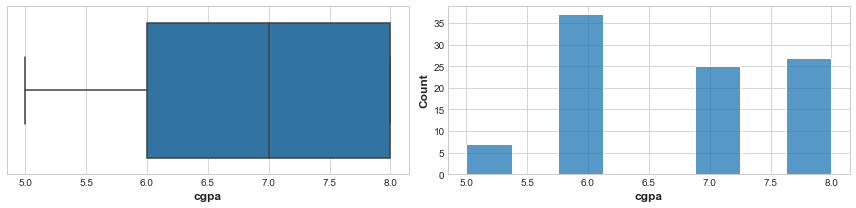

In [18]:
fig, ax = plt.subplots(1,2, figsize=(12,3))
sns.boxplot(ax=ax[0], x='cgpa', data=df_1)
sns.histplot(ax=ax[1], x='cgpa', data=df_1)
plt.show()

Indeed it looks like these 7 stuents can be considered as outliers. Also among students with similar features, they result to have a very low cgpa while being still placed. We can remove these students from the dataset.

We will then create a new dataframe called df_clean to host a cleaned version of the dataset.

In [19]:
df_clean = df.drop(list(df.loc[(df['cgpa'] == 5) & (df['placed'] == 1)].index))

In [20]:
print('We Removed {} outliers !'.format(len(df)-len(df_clean)))

We Removed 7 outliers !


The plots regarding the cleaned dataset are:

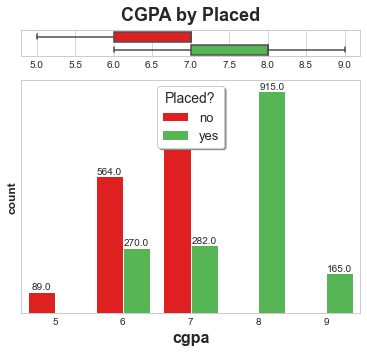

In [21]:
num_plot(df_clean, 'cgpa', 'CGPA by Placed', '')

# Q1 - Is CGPA independent from placement? (Chi-Square test)


## Hypothesis testing for categeorical variables indepedence

- H0: CGPA and placed are independent <br>
- H1: CGPA and placed are not independent

In [22]:
# Create a table of cross-tabulations
placed_cgpa = pd.crosstab(df_clean["placed"],df_clean["cgpa"])
print(placed_cgpa)

cgpa     5    6    7    8    9
placed                        
0       89  564  674    0    0
1        0  270  282  915  165


In [23]:
stat, p, dof, expected = chi2_contingency(placed_cgpa)
print('Degress of freedom = %d' % dof)
print('Expected frequencies ', expected)

Degress of freedom = 4
Expected frequencies  [[ 39.91314633 374.0175735  428.72997634 410.34302129  73.99628253]
 [ 49.08685367 459.9824265  527.27002366 504.65697871  91.00371747]]


In [24]:
prob = 0.95
critical = chi2.ppf(0.95, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

probability=0.950, critical=9.488, stat=1416.994


In [25]:
# interpret test-statistic
if abs(stat) >= critical:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

The variables are dependent (We reject H0)


In [26]:
# interpret p-value
alpha = 1.0 - prob
print('Significance = %.3f, p = %.3f' % (alpha, p))
if p <= alpha:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

Significance = 0.050, p = 0.000
The variables are dependent (We reject H0)


We can see that :
- The P-value is lower than the significance level of 5%, so we can reject the null hypothesis with a confidence of 95%.

- The Test-statistic is inferior than the critical value, so we can reject the null hypothesis with a confidence of 95%.

**This means, that cgpa and placement are not independent with a confidence level of 95%**

# How do internship numbers affect job placement?

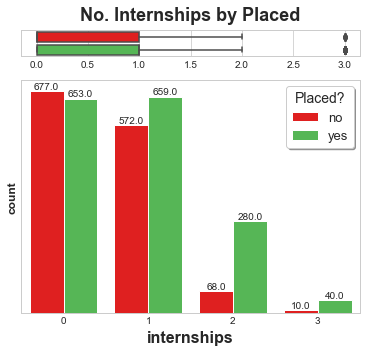

In [27]:
num_plot(df_clean, 'internships', 'No. Internships by Placed', '')

We can see that students who had 2 ore more internships tends to be placed.

Moreover, from the boxplots, we can see that students who did 3 internships are labeled as outliers, lets check!

# Analysis of students with many internships (3 internships)

In [28]:
df_int = df.loc[df['internships'] == 3]

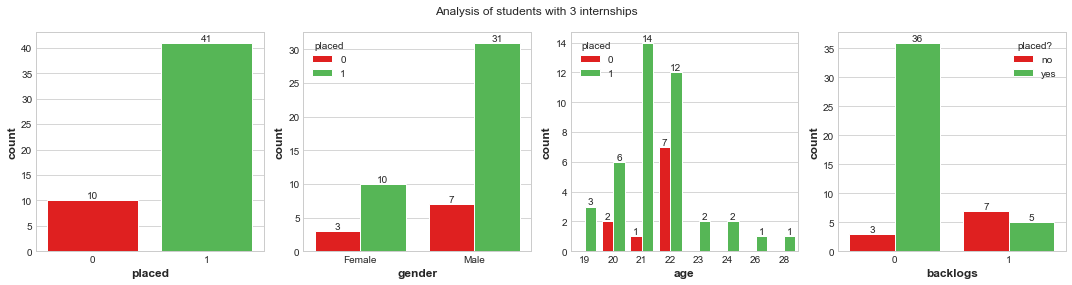

In [29]:
fig, ax = plt.subplots(1,4, figsize=(15,4))
plt.suptitle('Analysis of students with 3 internships')
sns.countplot(ax=ax[0], x='placed', data=df_int,palette=palette)
for container in ax[0].containers:
    ax[0].bar_label(container)
sns.countplot(ax=ax[1], x='gender', hue='placed', data=df_int,palette=palette)
for container in ax[1].containers:
    ax[1].bar_label(container)
sns.countplot(ax=ax[2], x='age', data=df_int, hue='placed',palette=palette)
for container in ax[2].containers:
    ax[2].bar_label(container)
sns.countplot(ax=ax[3], x='backlogs', hue='placed', data=df_int,palette=palette)
for container in ax[3].containers:
    ax[3].bar_label(container)
plt.legend(title='placed?', loc='upper right', labels=['no', 'yes'])
plt.show()

From these plots about students with 3 internships we can state:
- Most of the students are placed
- Most of them have no history of backlogs. In particular, the great majority of students with no backlogs got placed.
- The mean age is around 21-22 yo, with some students older than 22 who all got placed.

# Q2 - Does the number internships affect the probability of getting placed? (chi square test)

## Hypothesis testing for categeorical variables indepedence

- H0: Number of internships and placed are independent <br>
- H1: Number of internships and placed are not independent

In [30]:
# Create a table of cross-tabulations
table = pd.crosstab(df_clean["placed"],df_clean["internships"])
print(table)

internships    0    1    2   3
placed                        
0            677  572   68  10
1            653  659  280  40


In [31]:
stat, p, dof, expected = chi2_contingency(table)
print('Degress of freedom = %d' % dof)
print('Expected frequencies ', expected)

Degress of freedom = 3
Expected frequencies  [[596.45488341 552.05711389 156.06488679  22.42311592]
 [733.54511659 678.94288611 191.93511321  27.57688408]]


In [32]:
prob = 0.95
critical = chi2.ppf(0.95, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

probability=0.950, critical=7.815, stat=123.606


In [33]:
# interpret test-statistic
if abs(stat) >= critical:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

The variables are dependent (We reject H0)


In [34]:
# interpret p-value
alpha = 1.0 - prob
print('Significance = %.3f, p = %.3f' % (alpha, p))
if p <= alpha:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

Significance = 0.050, p = 0.000
The variables are dependent (We reject H0)


We can see that :
- The P-value is lower than the significance level of 5%, so we can reject the null hypothesis with a confidence of 95%.

- The Test-statistic is inferior than the critical value, so we can reject the null hypothesis with a confidence of 95%.

This means, that the number of internships affects placement.<br>
In particular, from the plots we could see that students who did 2 or more internships placed a job more than students who did less internships.

# Q3 - Is gender indepedent from 'placement'? (chi square test)

In the following we will carry out a chi square test to test if gender and placed are independent. In other words, we are asking ourselves if placement depends on sex or not.


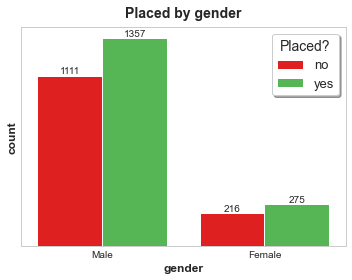

In [35]:
plt.figure(figsize=(5,4))
plt.title('Placed by gender')
g = sns.countplot(x='gender', data=df_clean, hue='placed',palette=palette)
for container in g.containers:
    g.bar_label(container)
plt.legend(title='Placed?', title_fontsize=14, labels=['no', 'yes'], fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.yticks([])
plt.show()

- H0: gender and placement are independent <br>
- H1: gender and placement are not dependent

In [36]:
# Create a table of cross-tabulations
table = pd.crosstab(df_clean["gender"],df_clean["placed"])
print(table)

placed     0     1
gender            
Female   216   275
Male    1111  1357


In [37]:
stat, p, dof, expected = chi2_contingency(table)
print('Degress of freedom = %d' % dof)
print('Expected frequencies ', expected)

Degress of freedom = 1
Expected frequencies  [[ 220.19499831  270.80500169]
 [1106.80500169 1361.19499831]]


In [38]:
prob = 0.95
critical = chi2.ppf(0.95, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))

probability=0.950, critical=3.841, stat=0.135


In [39]:
# interpret p-value
alpha = 1.0 - prob
print('Significance = %.3f, p = %.3f' % (alpha, p))
if p <= alpha:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

Significance = 0.050, p = 0.714
The variables are independent (We fail to reject H0)


The p-value is definitely higher than 0.05 (0.752), so at a 95% confidence level we cannot reject the null hypothesis of indipendence between gender and sex.

**Sex and placement are independent with a confidence of 95%.**

# Q4 - Does the number of backlogs affect the placement? (chi square test)

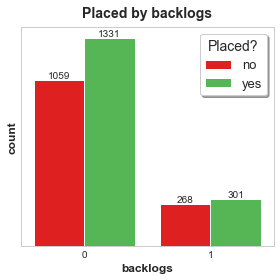

In [40]:
plt.figure(figsize=(4,4))
plt.title('Placed by backlogs')
g = sns.countplot(x='backlogs', data=df_clean, hue='placed',palette=palette)
for container in g.containers:
    g.bar_label(container)
plt.legend(title='Placed?', title_fontsize=14, labels=['no', 'yes'], fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.yticks([])
plt.show()

It is not clear if backlogs and placed are independent, we will carry out a chi square test to check it !

- H0: backlogs and placement are independent <br>
- H1: backlogs and placement are not independent

In [41]:
logs_plac = pd.crosstab(df_clean["backlogs"],df_clean["placed"])
print(logs_plac)

placed       0     1
backlogs            
0         1059  1331
1          268   301


In [42]:
stat, p, dof, expected = chi2_contingency(logs_plac)
print('Degress of freedom = %d' % dof)
print('Expected frequencies ', expected)

Degress of freedom = 1
Expected frequencies  [[1071.82494086 1318.17505914]
 [ 255.17505914  313.82494086]]


In [43]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
# interpret test-statistic
if abs(stat) >= critical:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('Significance = %.3f, p = %.3f' % (alpha, p))
if p <= alpha:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

probability=0.950, critical=3.841, stat=1.336
The variables are independent (We fail to reject H0)
Significance = 0.050, p = 0.248
The variables are independent (We fail to reject H0)




**From the test we conclude that we cannot reject the null hypotheis of independence between backlogs and placement with a confidence of 95%**

# Q5 - Does 'Hostel' affect the placement? (chi square test)

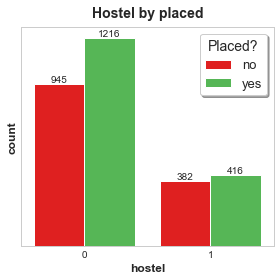

In [44]:
plt.figure(figsize=(4,4))
plt.title('Hostel by placed')
g = sns.countplot(x='hostel', data=df_clean, hue='placed',palette=palette)
for container in g.containers:
    g.bar_label(container)
plt.legend(title='Placed?', title_fontsize=14, labels=['no', 'yes'], fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.yticks([])
plt.show()

It is not clear if hostel and placed are independent, we will carry out a chi square test to check it !

- H0: hostel and placement are independent <br>
- H1: hostel and placement are not independent

In [45]:
host_plac = pd.crosstab(df_clean["hostel"],df_clean["placed"])
print(host_plac)

placed    0     1
hostel           
0       945  1216
1       382   416


In [46]:
stat, p, dof, expected = chi2_contingency(host_plac)
print('Degress of freedom = %d' % dof)
print('Expected frequencies ', expected)

Degress of freedom = 1
Expected frequencies  [[ 969.12706996 1191.87293004]
 [ 357.87293004  440.12706996]]


In [47]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
# interpret test-statistic
if abs(stat) >= critical:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('Significance = %.3f, p = %.3f' % (alpha, p))
if p <= alpha:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

probability=0.950, critical=3.841, stat=3.873
The variables are dependent (We reject H0)
Significance = 0.050, p = 0.049
The variables are dependent (We reject H0)


**We can conclude that the feature 'hostel' affects the placement. In particular, it looks like that students who didnt live in a college accomodation tended to be placed.**

# Q6 - Does age affect job placement?

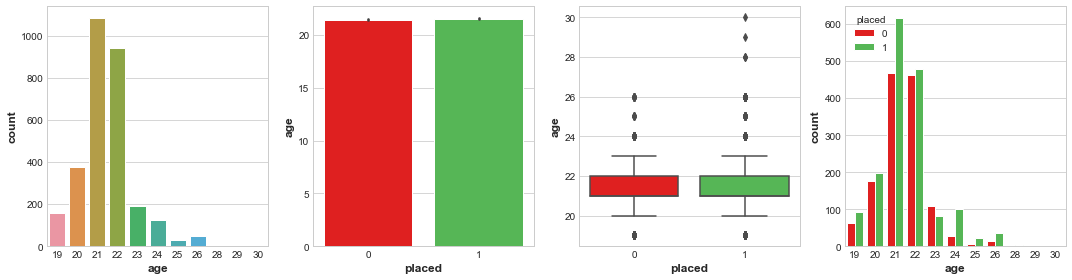

In [48]:
fig, ax = plt.subplots(1,4, figsize=(15,4))
sns.countplot(ax=ax[0], x='age', data=df_clean)
sns.barplot(ax=ax[1], x='placed', y='age', data=df_clean,palette=palette)
sns.boxplot(ax=ax[2], x='placed', y='age', data=df_clean,palette=palette)
sns.countplot(ax=ax[3], x='age', data=df_clean, hue='placed',palette=palette)
plt.show()

It seems like there is no clear relationship between age and 'placed'. For placed students, there are some outlier values of 'age' consisted of students with an age higher than 26.<br>
Who are these students?

In [49]:
df_clean.loc[(df_clean['age'] >26) & (df_clean['placed']==1)]

,age,gender,stream,internships,cgpa,hostel,backlogs,placed
448,28,Male,Civil,0,8,1,0,1
550,30,Male,Computer Science,1,8,0,0,1
1444,28,Female,Computer Science,3,8,1,0,1
2333,29,Female,Mechanical,1,8,1,0,1
2446,28,Male,Computer Science,0,6,0,0,1


It looks like that among these 5 students, all of them do not have any historical backlogs, 4 of them are from 'Computer Science, 4 of them have a quite high cgpa,one of them did 3 internships.

We will remove these outliers.

In [50]:
df_clean = df_clean.drop(list(df_clean.loc[(df_clean['age'] > 26) & (df_clean['placed']==1)].index))
print('In total we removed {} outliers !'.format(len(df)-len(df_clean)))

In total we removed 12 outliers !


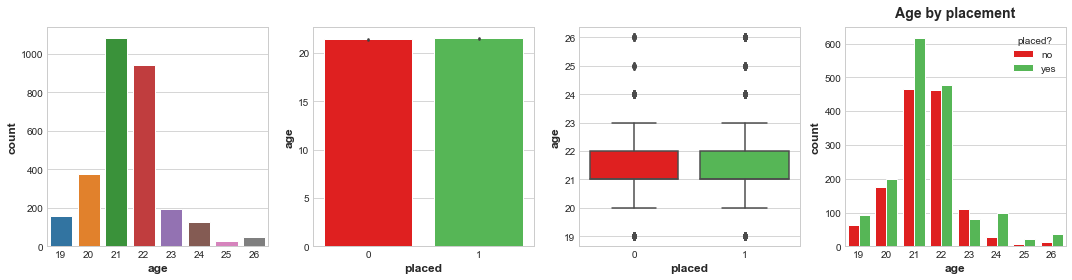

In [51]:
fig, ax = plt.subplots(1,4, figsize=(15,4))
sns.countplot(ax=ax[0], x='age', data=df_clean)
sns.barplot(ax=ax[1], x='placed', y='age', data=df_clean,palette=palette)
sns.boxplot(ax=ax[2], x='placed', y='age', data=df_clean,palette=palette)
sns.countplot(ax=ax[3], x='age', data=df_clean, hue='placed',palette=palette)
plt.legend(title='placed?', loc='upper right', labels=['no', 'yes'])
plt.title('Age by placement')
plt.tight_layout()
plt.show()

Age looks somewhat normal, we can check its normality though Wilk-Shapiro test!

In [52]:
stat, p = shapiro(df_clean.age)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian at 5% significance level (fail to reject H0)')
else:
	print('Sample does not look Gaussian at 5% significance level  (reject H0)')

Statistics=0.895, p=0.000
Sample does not look Gaussian at 5% significance level  (reject H0)


The test tells us that the data is not normal, what if we would not consider students with an age equal or higher than 25?

In [53]:
stat, p = shapiro(df_clean.loc[df_clean['age']<25].age)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian at 5% significance level (fail to reject H0)')
else:
	print('Sample does not look Gaussian at 5% significance level  (reject H0)')

Statistics=0.914, p=0.000
Sample does not look Gaussian at 5% significance level  (reject H0)


The statistics value increases a little bit, meaning that the distribution is more "normal" but still it is not normal at 5% significance level.

Next, it could be interesting to see who are these students with an age higher than 25, did they apply to jobs this late because they did lots of internships and graduated later?

# Q7 - Are the number of internships and age independent? (chi square test)
- H0: Age and internships are independent <br>
- H1: Age and internships are not independent

In [54]:
age_intern = pd.crosstab(df_clean["internships"],df_clean["age"])
print(age_intern)

age          19   20   21   22  23  24  25  26
internships                                   
0            71  187  498  384  93  58  15  22
1            64  147  421  420  85  58  10  24
2            18   33  150  118  12  10   4   3
3             3    8   15   19   2   1   0   1


In [55]:
stat, p, dof, expected = chi2_contingency(age_intern)
print('Degress of freedom = %d' % dof)
print('Expected frequencies ', expected)

Degress of freedom = 21
Expected frequencies  [[7.01313473e+01 1.68584970e+02 4.87322952e+02 4.23035884e+02
  8.63155044e+01 5.70941097e+01 1.30372376e+01 2.24779959e+01]
 [6.49031821e+01 1.56017265e+02 4.50993907e+02 3.91499323e+02
  7.98808395e+01 5.28378470e+01 1.20653351e+01 2.08023020e+01]
 [1.83777928e+01 4.41773866e+01 1.27702099e+02 1.10855789e+02
  2.26188219e+01 1.49614083e+01 3.41638456e+00 5.89031821e+00]
 [2.58767773e+00 6.22037915e+00 1.79810427e+01 1.56090047e+01
  3.18483412e+00 2.10663507e+00 4.81042654e-01 8.29383886e-01]]


In [56]:
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
# interpret test-statistic
if abs(stat) >= critical:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('Significance = %.3f, p = %.3f' % (alpha, p))
if p <= alpha:
	print('The variables are dependent (We reject H0)')
else:
	print('The variables are independent (We fail to reject H0)')

probability=0.950, critical=32.671, stat=31.659
The variables are independent (We fail to reject H0)
Significance = 0.050, p = 0.063
The variables are independent (We fail to reject H0)


**The p-value is close to 0.05, so it means that age and the number of internships are somewhat dependent.**

# Q8 - Does stream affect placement?

In [57]:
df_clean['stream'].value_counts()

Computer Science                 769
Information Technology           688
Electronics And Communication    424
Mechanical                       423
Electrical                       334
Civil                            316
Name: stream, dtype: int64

There are 6 different streams in this dataset, which look somewhat balanced.

We will rename some of these streams to improve the readability of the following plots.

In [58]:
df_clean['stream']=df_clean['stream'].replace('Computer Science','CS')
df_clean['stream']=df_clean['stream'].replace('Information Technology','IT')
df_clean['stream']=df_clean['stream'].replace('Electronics And Communication','Electronic')

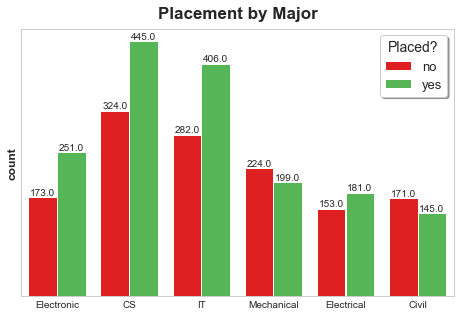

In [59]:
plt.figure(figsize=(6.5,4.5))
g=sns.countplot(x='stream', data=df_clean, hue='placed',palette=palette)
plt.yticks([])
plt.xlabel('')
for container in g.containers:
    g.bar_label(container,fmt='%.1f')
plt.legend(title='Placed?', title_fontsize=14, labels=['no', 'yes'], fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.title('Placement by Major', fontsize=17)
plt.show()

It looks like the majority of students from Computer Science, IT and Electronics and communication got placed.<br>
Since the situation looks more delicate with mechanical, civil and electrical engineering students, we will carry out chi square tests.

## Do Mechanical Engineers get placed less?

In [60]:
mechanical_ratio = df_clean.loc[df_clean['stream']=='Mechanical']['placed'].value_counts()
mechanical_ratio

0    224
1    199
Name: placed, dtype: int64

In [61]:
# Perform Chi-square test
chi= stats.chisquare(mechanical_ratio)
print(chi)

Power_divergenceResult(statistic=1.4775413711583925, pvalue=0.2241595941323075)


In [62]:
# Test significance
alpha= 0.05
if chi[1] < alpha:
    print("Difference is statistically significant with a 95% confidence")
else:
    print("No significant difference with a 95% confidence")

No significant difference with a 95% confidence


**The p-value is well above 5% (around 22.4%), so we fail to state statistical difference between job placement = 0 or 1 among Mechanical Engineers.<br>**

## Do Civil Engineers get placed less?

In [63]:
civil_ratio = df_clean.loc[df_clean['stream']=='Civil']['placed'].value_counts()
civil_ratio

0    171
1    145
Name: placed, dtype: int64

In [64]:
# Perform Chi-square test
chi= stats.chisquare(civil_ratio)
print(chi)

Power_divergenceResult(statistic=2.1392405063291138, pvalue=0.14357295597764955)


In [65]:
# Test significance
alpha= 0.05
if chi[1] < alpha:
    print("Difference is statistically significant with a 95% confidence")
else:
    print("No significant difference with a 95% confidence")

No significant difference with a 95% confidence


**The p-value is higher than 5% (14%), so we fail to state statistical difference between job placement = 0 or 1 among Civil Engineers. It is interesting to notice that the p value is smaller in this case compared to the previous test about mechanical engineering.**

## What about Electrical Engineers?

In [66]:
electrical_ratio = df_clean.loc[df_clean['stream']=='Electrical']['placed'].value_counts()

In [67]:
chi = stats.chisquare(electrical_ratio)
chi

Power_divergenceResult(statistic=2.3473053892215567, pvalue=0.12549977446847638)

In [68]:
# Test significance
alpha= 0.05
if chi[1] < alpha:
    print("Difference is statistically significant with a 95% confidence")
else:
    print("No significant difference with a 95% confidence")

No significant difference with a 95% confidence


**Also for Electrical Engineers, no difference could be found with a 95% confidence.**

We can conclude that only for Computer Science, IT, Electronics and communication there is a statstical difference between job placement. 

# Q9 - Is there a relationship between stream and the other features?

## Stream VS Hostel

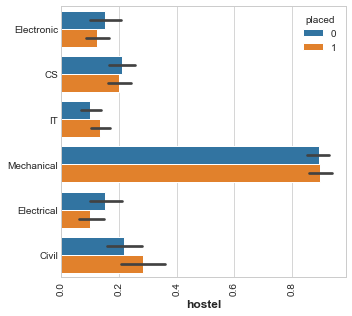

In [69]:
plt.figure(figsize=(5,4.5))
sns.barplot(y='stream', x='hostel',data=df_clean, hue='placed')
plt.xticks(rotation=90);
plt.ylabel('');

**It looks like the vast majority of Mechanical Engineers lives in a college accomodation**

## Stream VS gender

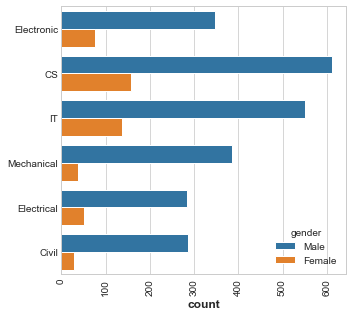

In [70]:
plt.figure(figsize=(5,4.5))
sns.countplot(y='stream',data=df_clean, hue='gender')
plt.xticks(rotation=90);
plt.ylabel('');

**We can see that overall the majority of students is male for every Stream.**

In [71]:
x, y = 'stream', 'internships'
df1 = df_clean.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent(%)').reset_index()

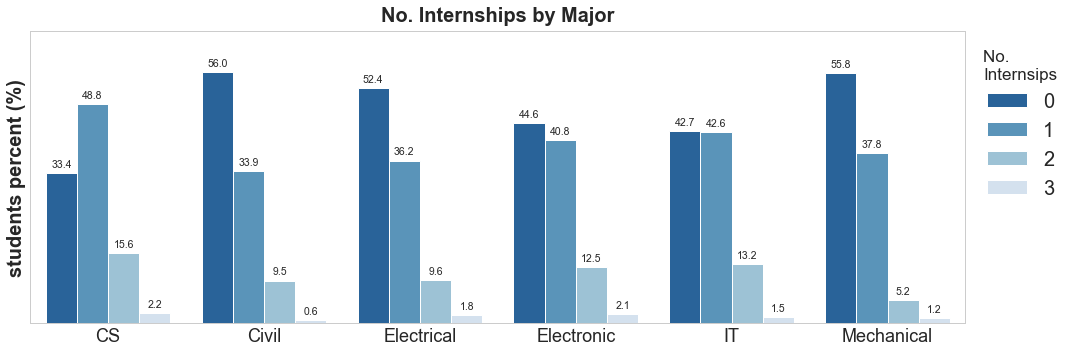

In [72]:
plt.figure(figsize=(15,5))
g = sns.barplot(x=x,y='percent(%)',hue=y,data=df1, palette='Blues_r')
plt.legend(title='No. \nInternsips',bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True,fontsize=20,title_fontsize=17)
plt.xlabel('')
plt.ylim(0, 65)
plt.ylabel('students percent (%)',fontsize=20)
for container in g.containers:
    g.bar_label(container, padding = 4, fmt='%.1f', fontsize=10.5)
plt.yticks([])
plt.xticks(fontsize=18)
plt.title('No. Internships by Major', fontsize=20)
plt.show()

**We can see the major where most students did at least one internship is Computer Science (67%), while for Civil, Electrical and Mechanical engineering more than half of the students did not do any internship. Morevoer, Electronic and IT are the majors where most students did 2 or more internships.**

In [73]:
x, y = 'stream', 'cgpa'
df1 = df_clean.groupby(x)[y].value_counts(normalize=True)
df1 = df1.mul(100)
df1 = df1.rename('percent(%)').reset_index()

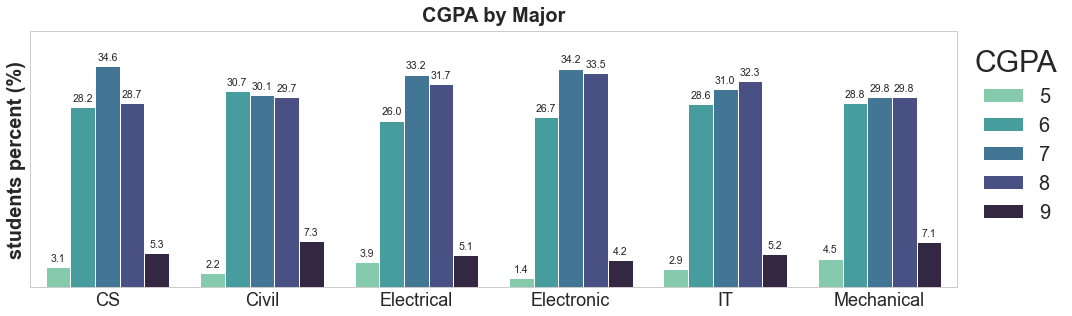

In [74]:
plt.figure(figsize=(15,4.5))
g = sns.barplot(x='stream', y='percent(%)',hue='cgpa',data=df1, palette='mako_r')
plt.legend(title='CGPA',bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, fontsize=20,title_fontsize=30)
plt.xlabel('')
plt.ylim(0, 40)
plt.ylabel('students percent (%)',fontsize=20)
for container in g.containers:
    g.bar_label(container, padding = 4, fmt='%.1f', fontsize=10.5)
plt.yticks([])
plt.xticks(fontsize=18)
plt.title('CGPA by Major', fontsize=20)
plt.show()

**We can see that Civil and Mechanical are the majors where over 7% of the students have CGPA=9, whereas students from Electrical engineering are those with most CGPA=8 or CGPA=7.**

In the following, ML algorithms will be trained to predict the placement of students.

# Data preprocessing

In [75]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2954 entries, 0 to 2965
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          2954 non-null   int64 
 1   gender       2954 non-null   object
 2   stream       2954 non-null   object
 3   internships  2954 non-null   int64 
 4   cgpa         2954 non-null   int64 
 5   hostel       2954 non-null   int64 
 6   backlogs     2954 non-null   int64 
 7   placed       2954 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 272.2+ KB


## Encoding

Since there is no order/hierarchy among the categorical features, they will be encoded by One hot encoding (using pd.get_dummies)

In [76]:
df_encoded = pd.get_dummies(df_clean, drop_first=True)

In [77]:
df_encoded.head()

,age,internships,cgpa,hostel,backlogs,placed,gender_Male,stream_Civil,stream_Electrical,stream_Electronic,stream_IT,stream_Mechanical
0,22,1,8,1,1,1,1,0,0,1,0,0
1,21,0,7,1,1,1,0,0,0,0,0,0
2,22,1,6,0,0,1,0,0,0,0,1,0
3,21,0,8,0,1,1,1,0,0,0,1,0
4,22,0,8,1,0,1,1,0,0,0,0,1


In [78]:
X = df_encoded.drop('placed', axis=1)
y = df_encoded['placed']

## Train test split

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=seed)